# Working with py_SBeLT's Data Storage

The `py_SBeLT` model stores data from each run in an .hdf5 file. This notebook will provide a quick walkthrough of _what_ is stored for each run, _where_ it is stored in the .hdf5 file, and _how_ to access the data once a run is complete.  



## What Data is Stored?

### Per-iteration saves

At the end of each iteration the following are saved:
- an array of the model particles (`model`)
- an array of IDs representing the event particles (`event_ids`)

So if there are 20 iterations in a model run, then there will be 20 model particle arrays saved and 20 event particle arrays saved. Also note that because the structures are saved at the end of an iteration, the array of model particles represents the state of the model particles _after_ entrainment took place during that iteration. 

### Single saves

Before any iterations take place, the following are saved:
- the array of the model particles as they were placed on initialization (`model`)
- the array of the bed particles (`bed`)

After the iterations have completed the following are saved:
- arrays of # of crossings each iteration at each subregion's downstream boundary (`subregion-i-flux`)
- array of average age of particles each iteration (`avg_age`)
- array of age range of particle each iteration (`age_range`)

## Where is it Stored?

All the data mentioned above is written to an `.hdf5` file over the duration of a model run. HDF5 files are composed of Groups and Datasets. Groups can be thought of as folders and Datasets are simply sets of data/data values/structures. To organize the `py_SBeLT data`, there are $4 + N$ groups, where $N$ is the number of iterations.

See Figure 1 below for a diagram of the data storage procedure. Blue squares with rounded edges represent Groups, green rectangles represent dataset _names_ and grey ovals represent the actual data stored.

|![sbelt data storage diagram](sbelt_data_storage.png)
|:--:|
| Figure 1. Diagram of py_SBeLT's data storage procedure. |

## How to Access the Data?

To gain better intuition for working with `py_SBeLT`'s data storage, let's run a `sbelt` run and then retrieve some of that stored data and derive some metrics.

In [ ]:
!pip install sbelt

In [4]:
import h5py
import numpy as np

In [ ]:
from sbelt import sbelt_runner
sbelt_runner.run(iterations=100)

### Accessing the Parameters

The first step to accessing the data is to open the desired `.hdf5` file. There are a handful of ways to open a `.hdf5` file, but using a context manager (`with ...`) is useful because we don't have to remember to close the file once we're done out operations. Let's start with opening the file and retrieving some parameters used for the run. 

In [8]:
# This won't get you data!
with h5py.File('sbelt-out.hdf5', 'r') as file:
    parameters = file['params']
    print(parameters)

<HDF5 group "/params" (14 members)>


We can see above that printing the parameters just returns an `HDF5 group`, which tells us we tried to access a Group instead of a Dataset. Let's try again, but instead once we've indexed into the 'params' group we also index for specific parameters: `iterations`, `bed_length`, and `poiss_lambda`. 

In [11]:
# This will get you data!
with h5py.File('sbelt-out.hdf5', 'r') as file:
    iterations = file['params']['iterations'][()] # add [()] to grab values from a dataset struc 
    bed_length = file['params']['bed_length'][()]
    poiss_lambda = file['params']['poiss_lambda'][()]
    print(iterations, bed_length, poiss_lambda)

100 100 5


### Accessing the Model Particle Arrays

Each iteration, the state of all the model particles is saved in an array. Let's access these arrays and compute a sample metric. For an example, let's find the maximum and minimum distance (mm) moved in the stream starting from the end of iteration 12 and ending at the end of iteration 20.

When accessing model particle arrays, take care to note that the iterations are numbered `0...N-1` where `N` is the number of total iterations. So, the second iteration will be at `iteration_1` and so on.

In [27]:
with h5py.File('sbelt-out.hdf5', 'r') as file:
    model_iteration_12 = np.array(file['iteration_11']['model'])
    model_iteration_20 = np.array(file['iteration_19']['model'])

# x locations are stored in the 0-th index of model particle arrays
iteration_12_x = model_iteration_12[:,0]
iteration_20_x = model_iteration_20[:,0]

particle_distance_traveled = iteration_20_x - iteration_12_x

# Recall that when particle exceed the stream bed they are sent back to the upstream value.
# For simplicity, let's ignore those cases and only look at non-looped distances.

particle_distance_traveled = particle_distance_traveled[particle_distance_traveled >= 0] # ignore looped distances (negative)
particle_max_move = np.max(particle_distance_traveled)
particle_min_move = np.min(particle_distance_traveled)


print(f'The maximum distance moved was {particle_max_move} mm while the minimum distance was {particle_min_move} mm')

The maximum distance moved was 17.75 mm while the minimum distance was 0.0 mm


### Accessing the Final Metrics

Finally, let's look at accessing the data stored in the `final_metrics` group. The data is the average age of particles per-iteration, the age range of particles per-iteration, and the crossings for each subregion per-iteration. They are all 1D NumPy arrays whose length is $N$ where $N$ is the number of iterations.

In [29]:
from matplotlib import pyplot as plt

In [31]:
with h5py.File('sbelt-out.hdf5', 'r') as file:
    avg_age = np.array(file['final_metrics']['avg_age'])
    age_range = np.array(file['final_metrics']['age_range'])

Text(0, 0.5, 'Average age (# of iterations since last hop)')

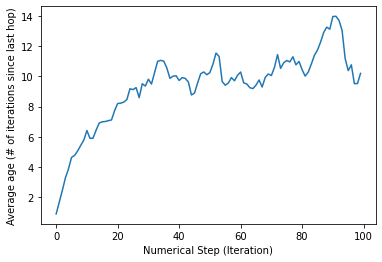

In [35]:
time = np.arange(0, len(avg_age))
plt.plot(time, avg_age)
plt.xlabel('Numerical Step (Iteration)')
plt.ylabel('Average age (# of iterations since last hop)')

Text(0, 0.5, 'Age range (Max - min)')

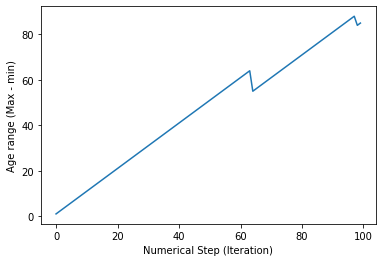

In [37]:
plt.plot(time, age_range)
plt.xlabel('Numerical Step (Iteration)')
plt.ylabel('Age range (Max - min)')

Next, let's look at the subregion crossings. As can be seen in Figure 1, the data is stored in a sub-group named `subregions` and the dataset name for each list of crossings is `subregion-i-flux` where $i$ is the subregion of interest. Note that subregions are numbered `0...K-1` where $K$ is the number of subregions.

In [39]:
with h5py.File('sbelt-out.hdf5', 'r') as file:
    n_sub = file['params']['num_subregions'][()]
    print(n_sub)

4


There are 4 subregions so we need to use the keys `subregion-0-flux`, `subregion-1-flux`, `subregion-2-flux`, and `subregion-3-flux` to retireve all the data.

In [40]:
with h5py.File('sbelt-out.hdf5', 'r') as file:
    sub_0_crossing = np.array(file['final_metrics']['subregions']['subregion-0-flux'])
    sub_1_crossing = np.array(file['final_metrics']['subregions']['subregion-1-flux'])
    sub_2_crossing = np.array(file['final_metrics']['subregions']['subregion-2-flux'])
    sub_3_crossing = np.array(file['final_metrics']['subregions']['subregion-3-flux'])

Text(0, 0.5, 'Number of crossings at downstream boundary')

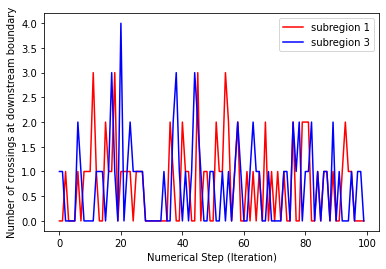

In [52]:
# Compare just subregion 0 and 3 for a simpler visualization
plt.plot(time, sub_0_crossing, 'r-', label='subregion 1')
plt.plot(time, sub_3_crossing, 'b-', label='subregion 3')
plt.legend()
plt.xlabel('Numerical Step (Iteration)')
plt.ylabel('Number of crossings at downstream boundary')